In [1]:
import simu_process.simulation as sim
from tools.generate_config import gen_config
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def simulate_get_output(config_list):
    """
    run simulations and generate config files with different alpha values
    @param config_list: list of paths of config files
    @return: a list of all output files
    """
    output_files = []
    for config in config_list:
        print(f'Run the simulations with config file: {config}')
        simu = sim.Simulation(config)
        simu.run_and_save()
        output = simu.output_file
        output_files.append(output)
    return output_files


def concat_results(output_files):
    """
    get results data from output files for further analysis
    @param output_files: a list out output files
    @return: user_all and cc_all, general results of the files
    """
    u_list = []
    cc_list = []
    for i in output_files:
        # find alpha value
        alpha = i[i.find('alpha')+5: i.find('.pkl')]
        with open(i, 'rb') as file:
            loaded_data = pickle.load(file)
            user_df = loaded_data[0]
            cc_df = loaded_data[1]
            user_df['alpha'] = float(alpha)
            cc_df['alpha'] = float(alpha)
            u_list.append(user_df)
            cc_list.append(cc_df)
    user_all = pd.concat(u_list).reset_index(drop=True)
    cc_all = pd.concat(cc_list)
    return user_all, cc_all

In [130]:
def user_searching_proportion(user_all):
    """
    Get the proportion of users stop searching at each step
    @param user_all: dataframe of user results after absorbed
    @return: dataframe with alpha, step, and proportion of users finish searching
    """
    all_counts = user_all.groupby('alpha')['id'].count()
    steps_counts = user_all.groupby(['alpha', 'steps'])['id'].count()
    ratios = steps_counts.div(all_counts, level='alpha').reset_index()
    ratios['proportion'] = ratios.groupby('alpha')['id'].cumsum()
    return ratios

def simu_stop_proportion(user_all, step_list):
    """
    get proportion of simulations stop at each step
    @param step_list: [1, 10, 20, 50, 200, 900] the threshold of steps
    @param user_all: dataframe of user results
    @return: dataframe with alpha, step, and proportion of iterations finished at the step
    """

    max_steps = user_all.groupby(['alpha', 'iteration'])['steps'].max().reset_index()

    result = []
    for step_threshold in step_list:
        step_counts = max_steps[max_steps['steps'] <= step_threshold].groupby('alpha')['iteration'].count()
        total_iterations = max_steps.groupby('alpha')['iteration'].count()
        proportions = step_counts / total_iterations
        #
        prop_df = pd.DataFrame(proportions).reset_index()
        prop_df['threshold'] = step_threshold
        result.append(prop_df)

    proportion_df = pd.concat(result)
    # proportion_df.columns = step_list

    # all_counts = max_steps.groupby('alpha')['iteration'].count()
    # steps_counts = max_steps.groupby(['alpha', 'steps'])['iteration'].count()
    # ratios = steps_counts.div(all_counts, level='alpha').reset_index()
    return proportion_df #.reset_index()

In [53]:
def cc_fair(cc_all):
    """
    Get the proportion of IF for each quality
    @param cc_all:
    @return: DataFrame of values of alphas, ids, proportion of IF
    """
    cc_all['rank'] = cc_all.groupby(['iteration', 'alpha'])['subs'].rank(ascending=False)
    cc_all['IF'] = cc_all['rank'] <= cc_all['id']
    fair_ratio = cc_all.groupby(['alpha', 'id'])['IF'].mean().reset_index()
    return fair_ratio


In [ ]:
# TODO: choose one iteration results to do the analysis of frequency, quality and subscribers, and with different tolerance, notice usually how many ccs can be followed

## Preprocess
In this part, we first run the simulations and pre-process the output files of the simulations

In [5]:
# If already run the simulation, skip this cell
base_file = 'config.yaml'
value = 'alpha'
value_list = [-1000, -50, -10, -5, -2.5, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50]
"""
 TODO: extreme PA
"""
# get the file names of the config files
config_list = gen_config(base_file, value, value_list)
# run simulation and get output paths
output_files = simulate_get_output(config_list)

Run the simulations with config file: /Users/gee/PycharmProjects/Fairness-for-SMI/config/configalpha_-1000.yaml


Iterations: 100%|██████████| 100/100 [02:20<00:00,  1.41s/it]


Run the simulations with config file: /Users/gee/PycharmProjects/Fairness-for-SMI/config/configalpha_-50.yaml


Iterations: 100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


Run the simulations with config file: /Users/gee/PycharmProjects/Fairness-for-SMI/config/configalpha_-10.yaml


Iterations: 100%|██████████| 100/100 [01:47<00:00,  1.07s/it]


Run the simulations with config file: /Users/gee/PycharmProjects/Fairness-for-SMI/config/configalpha_-5.yaml


Iterations: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Run the simulations with config file: /Users/gee/PycharmProjects/Fairness-for-SMI/config/configalpha_-2.5.yaml


Iterations: 100%|██████████| 100/100 [01:52<00:00,  1.12s/it]


Run the simulations with config file: /Users/gee/PycharmProjects/Fairness-for-SMI/config/configalpha_-1.yaml


Iterations: 100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


Run the simulations with config file: /Users/gee/PycharmProjects/Fairness-for-SMI/config/configalpha_-0.75.yaml


Iterations: 100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


Run the simulations with config file: /Users/gee/PycharmProjects/Fairness-for-SMI/config/configalpha_-0.5.yaml


Iterations: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


Run the simulations with config file: /Users/gee/PycharmProjects/Fairness-for-SMI/config/configalpha_-0.25.yaml


Iterations: 100%|██████████| 100/100 [01:22<00:00,  1.22it/s]


Run the simulations with config file: /Users/gee/PycharmProjects/Fairness-for-SMI/config/configalpha_0.yaml


Iterations: 100%|██████████| 100/100 [01:22<00:00,  1.22it/s]


Run the simulations with config file: /Users/gee/PycharmProjects/Fairness-for-SMI/config/configalpha_0.25.yaml


Iterations: 100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


Run the simulations with config file: /Users/gee/PycharmProjects/Fairness-for-SMI/config/configalpha_0.5.yaml


Iterations: 100%|██████████| 100/100 [01:24<00:00,  1.19it/s]


Run the simulations with config file: /Users/gee/PycharmProjects/Fairness-for-SMI/config/configalpha_0.75.yaml


Iterations: 100%|██████████| 100/100 [31:09<00:00, 18.70s/it]  


Run the simulations with config file: /Users/gee/PycharmProjects/Fairness-for-SMI/config/configalpha_1.yaml


Iterations: 100%|██████████| 100/100 [02:02<00:00,  1.23s/it]


Run the simulations with config file: /Users/gee/PycharmProjects/Fairness-for-SMI/config/configalpha_2.5.yaml


Iterations: 100%|██████████| 100/100 [05:11<00:00,  3.12s/it]


Run the simulations with config file: /Users/gee/PycharmProjects/Fairness-for-SMI/config/configalpha_5.yaml


Iterations:  15%|█▌        | 15/100 [8:07:24<46:01:58, 1949.63s/it]


KeyboardInterrupt: 

In [12]:
# For analysis after finish simulations
value_list = [-1000, -50, -10, -5, -2.5, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 2.5]
output_files = [f'/Users/gee/PycharmProjects/Fairness-for-SMI/_output/iter100alpha{alpha}.pkl' for alpha in value_list]

In [54]:
user_all, cc_all = concat_results(output_files)


## Analysis
The individual Fairness of the CCs.

In [50]:
# define the plot function
def plot(df, a, b, c):

    custom_palette = sns.diverging_palette(255, 1, n=10)
    # sns.set_palette(custom_palette)
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x=b, y=c, hue=a, palette=custom_palette)

    plt.xlabel('CCs')
    plt.ylabel(c)
    plt.title('The proportion of IF for each CC quality')
    plt.legend(title=a)
    plt.show()

In [55]:
# generate fair DataFrame
simu_time_df = simu_stop_proportion(user_all)
cc_fair_df = cc_fair(cc_all)

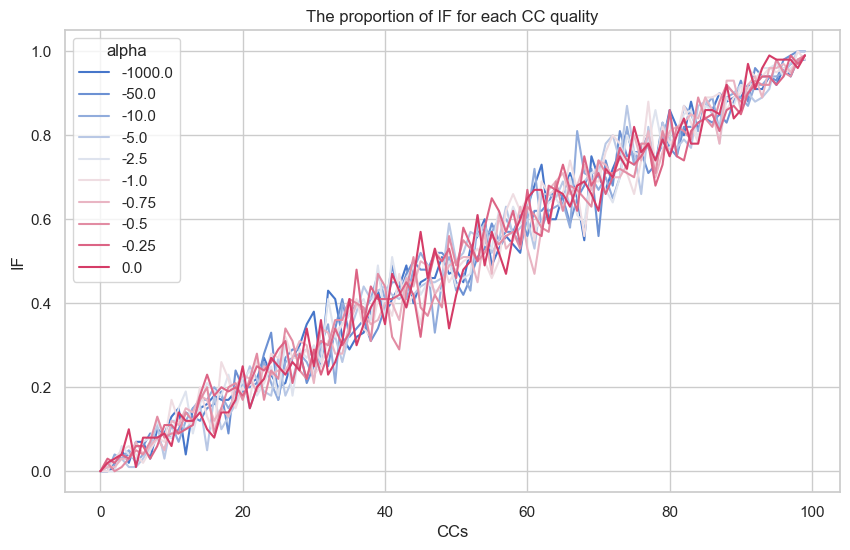

/var/folders/h2/7mqn1y3d1jzb7m_drwyf7njm0000gn/T/ipykernel_44699/69483386.py:13: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.lineplot(data=df, x=b, y=c, hue=a, palette=custom_palette) #, marker='o'


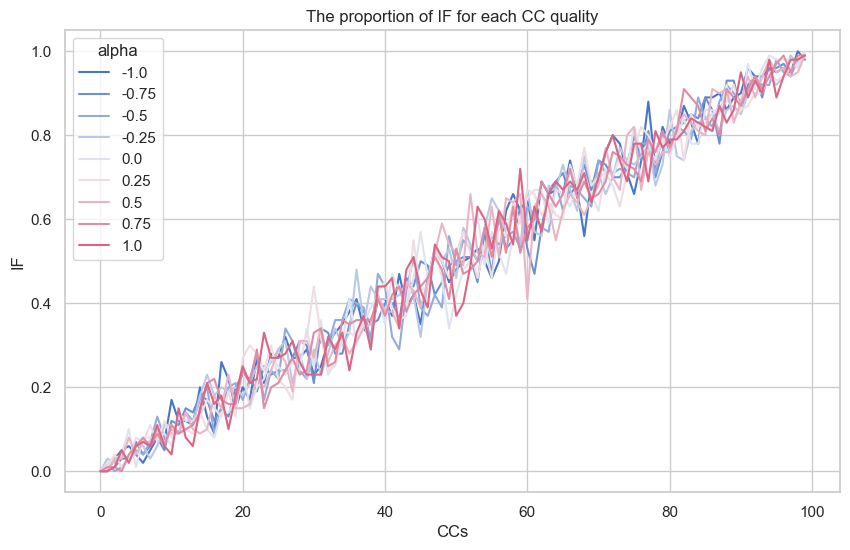

/var/folders/h2/7mqn1y3d1jzb7m_drwyf7njm0000gn/T/ipykernel_44699/69483386.py:13: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.lineplot(data=df, x=b, y=c, hue=a, palette=custom_palette) #, marker='o'


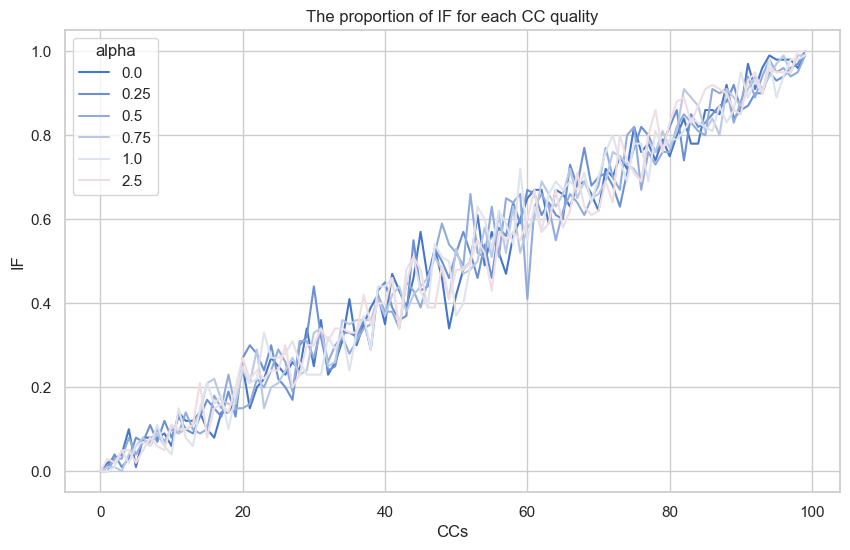

In [56]:
# plot the alpha separately
alpha_anti = [-1000, -50, -10, -5, -2.5, -1, -0.75, -0.5, -0.25, 0]
alpha_UR = [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]
alpha_PA = [0, 0.25, 0.5, 0.75, 1, 2.5]
for i in [alpha_anti, alpha_UR, alpha_PA]:
    filtered_fair = cc_fair_df[cc_fair_df['alpha'].isin(i)]
    plot(filtered_fair, 'alpha', 'id', 'IF')

Describe the correlation between frequency, quality and # of followers

In [62]:
# choose a sumulation result for the
cc_one = cc_all[cc_all['iteration'] == 5]
alpha_list = [-1000, -2.5, -1, 0, 1, 2.5]
# for i in alpha_list:
#     df_i = cc_one[cc_one['alpha'] == i]


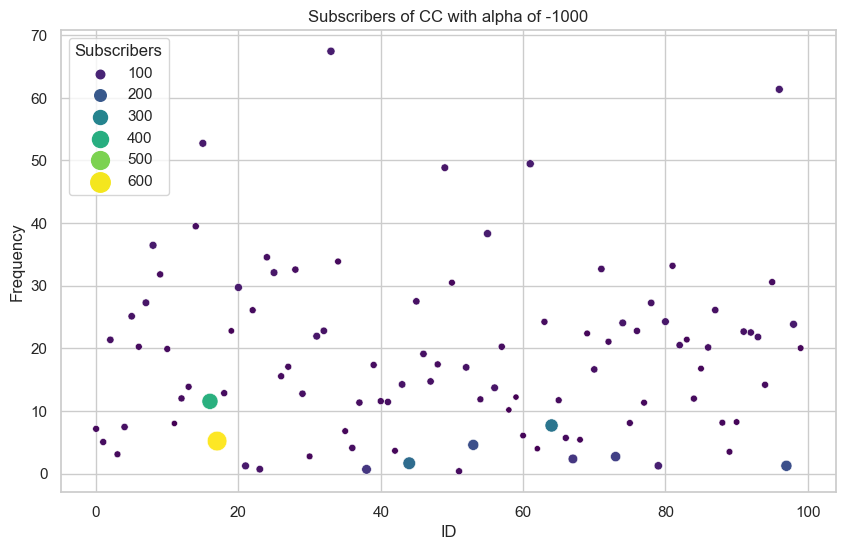

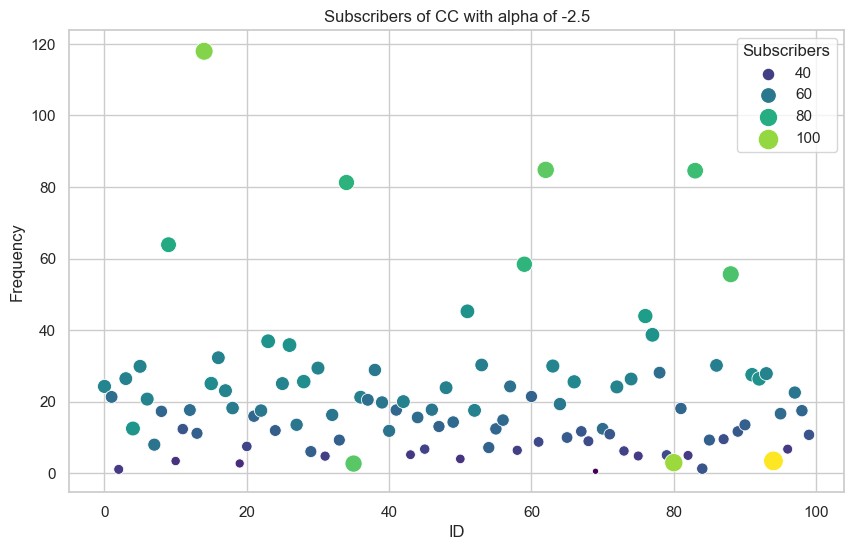

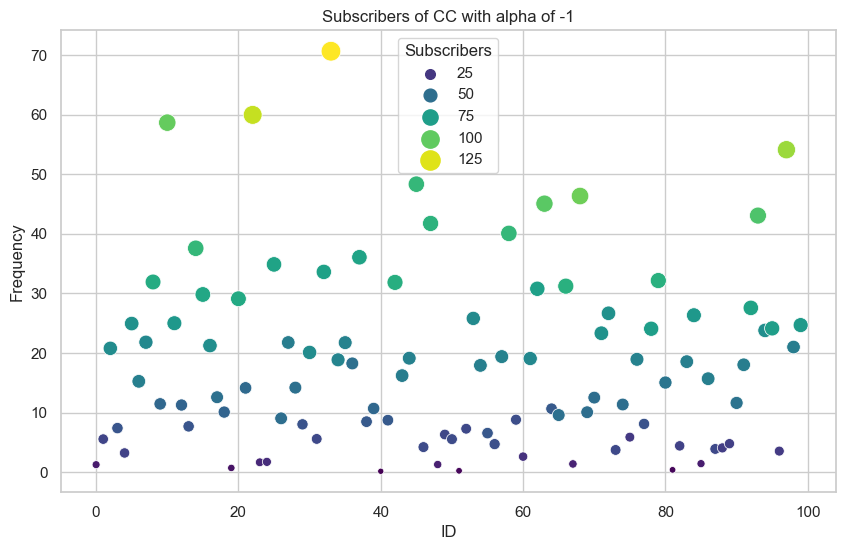

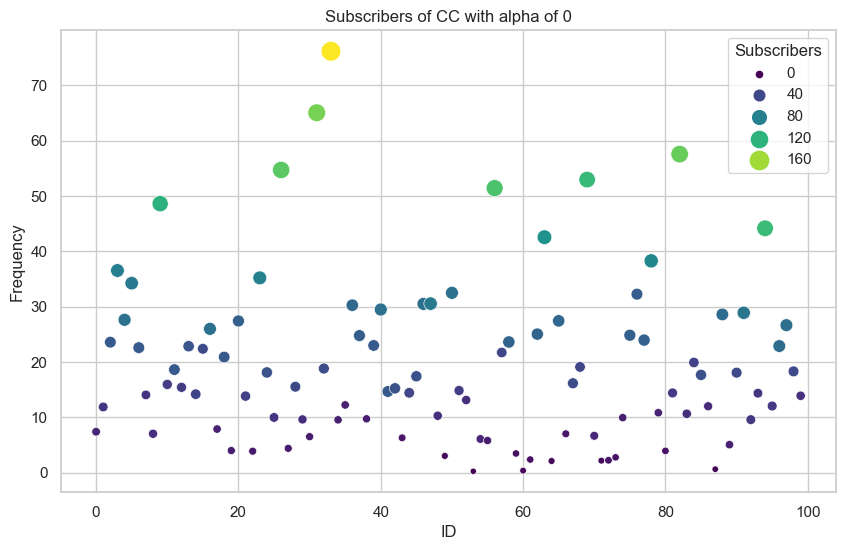

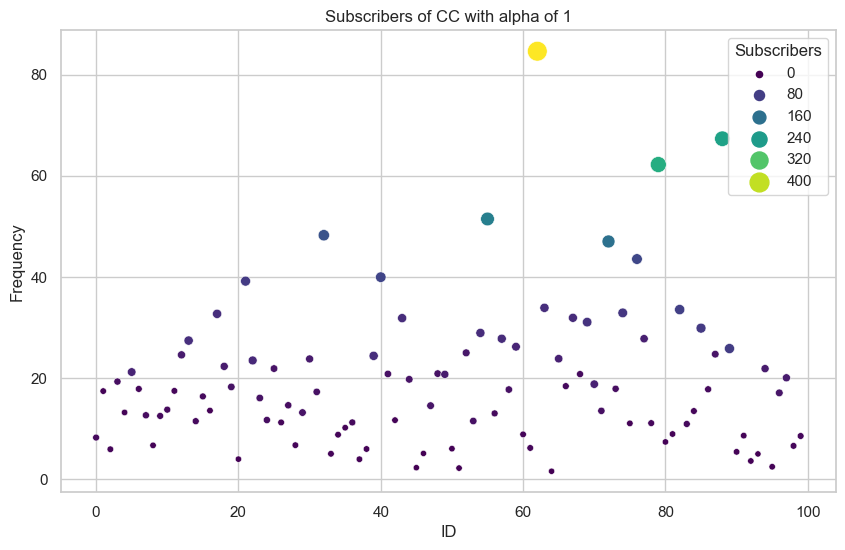

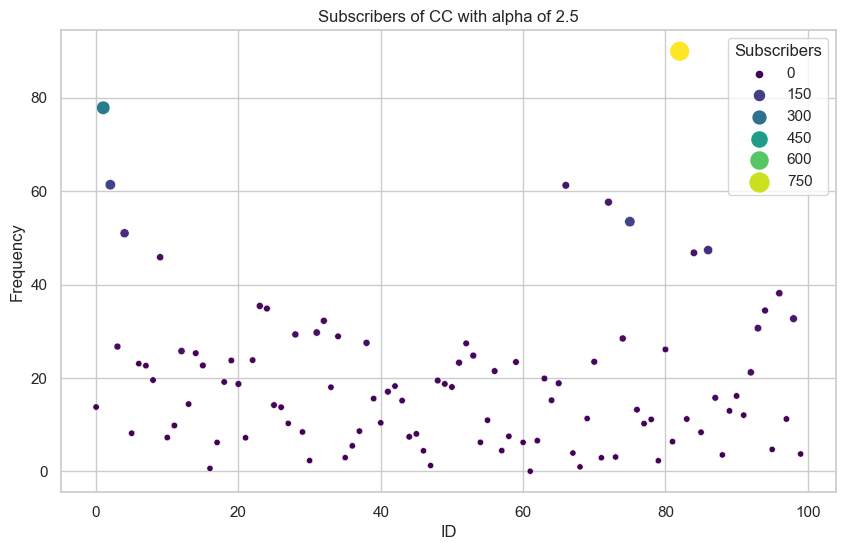

In [68]:
# Todo: combine different values

#
for alpha in alpha_list:
    df_i = cc_one[cc_one['alpha'] == alpha]
    plt.figure(figsize=(10, 6))  # 设置图像大小
    ax = plt.gca()
    sns.scatterplot(data=df_i, x='id', y='freq', size='subs', hue='subs', sizes=(20, 200), palette='viridis', ax=ax)

    plt.xlabel('ID')  # 设置横坐标标签
    plt.ylabel('Frequency')  # 设置纵坐标标签
    plt.title(f'Subscribers of CC with alpha of {alpha}')  # 设置标题
    plt.legend(title='Subscribers')  # 设置图例标题
    plt.show()

Plot the converged proportion at different steps

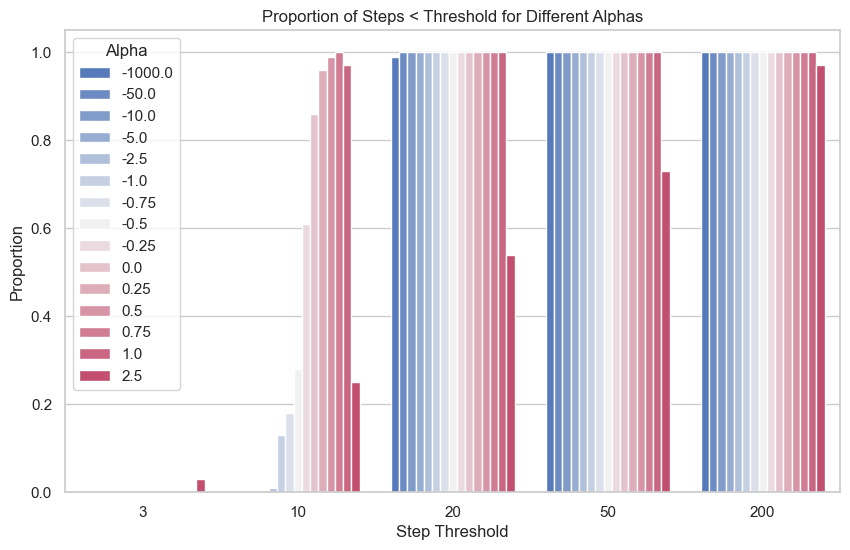

In [159]:
step_list = [3, 10, 20, 50, 200]
a = simu_stop_proportion(user_all, step_list)
# colors = sns.color_palette("husl", n_colors=len(a))
colors = sns.diverging_palette(255, 1, n=15)
plt.figure(figsize=(10, 6))

# 使用 Seaborn 绘制柱状图
sns.barplot(x='threshold', y='iteration', data=a, hue='alpha', palette=colors)

plt.xlabel('Step Threshold')
plt.ylabel('Proportion')
plt.title('Proportion of Steps < Threshold for Different Alphas')
plt.legend(loc='upper left', title='Alpha')

plt.show()

Analysis from user side,

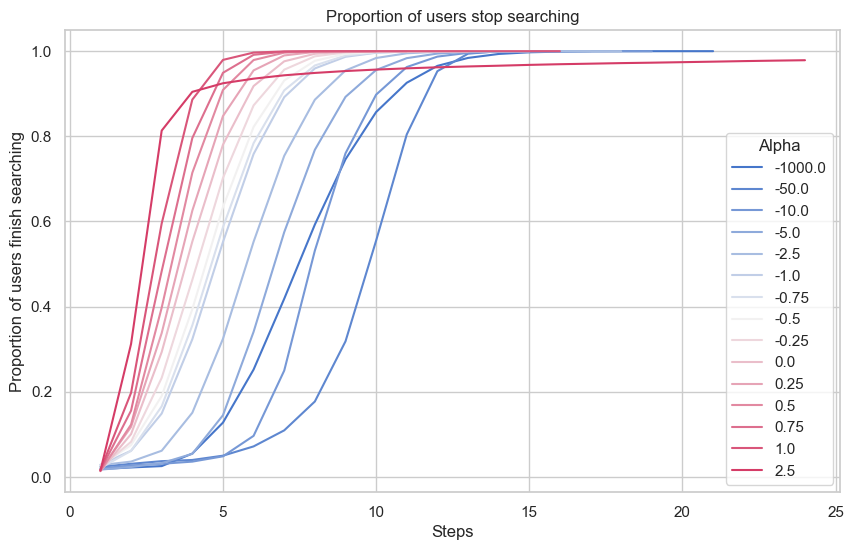

In [152]:
# since some iterations (PA) need more steps for converged, I slice the step value at 25
user_proportion = user_searching_proportion(user_all)
b = user_proportion[user_proportion['steps']<25]

colors = sns.diverging_palette(255, 1, n=15)
plt.figure(figsize=(10, 6))

# 使用 Seaborn 绘制柱状图
sns.lineplot(x='steps', y='proportion', data=b, hue='alpha', palette=colors)

plt.xlabel('Steps')
plt.ylabel('Proportion of users finish searching')
plt.title('Proportion of users stop searching')
plt.legend(title='Alpha')

plt.show()

In [155]:
user_all['satisfaction'] = [100 - min(followed) for followed in user_all['followed']]

In [157]:
user_all.groupby('alpha')['satisfaction'].mean()

alpha
-1000.00    87.93230
-50.00      90.39516
-10.00      88.80094
-5.00       87.21821
-2.50       85.37095
-1.00       82.89163
-0.75       82.62848
-0.50       81.75137
-0.25       81.03679
 0.00       80.25386
 0.25       79.42483
 0.50       78.75100
 0.75       75.86566
 1.00       74.46998
 2.50       73.82367
Name: satisfaction, dtype: float64